<a href="https://colab.research.google.com/github/bengsoon/lstm_lord_of_the_rings/blob/main/LOTR_LSTM_Character_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating a Language Model with LSTM using Lord of The Rings Corpus
In this notebook, we will create a character-level language language model using LSTM.

### Imports

In [21]:
# set up GitHub API 
# !pip install ghapi
from ghapi.all import GhApi
!source /content/drive/MyDrive/Colab\ Notebooks/git_auth.sh

gh_api = GhApi(owner="bengsoon", repo="lstm_lord_of_the_rings")

In [22]:
gh_api.git.get_ref(owner="bengsoon", repo="lstm_lord_of_the_rings")

HTTP404NotFoundError: ignored

In [6]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, Input, LSTM, Flatten, Dense, Dropout
from tensorflow.keras import Model
import numpy as np 

from pprint import pprint as pp
from string import punctuation
import regex as re
import random
import os
from ghapi.all import GhApi

### Data Preprocessing & Pipeline

In [2]:
# get LOTR full text
# !wget https://raw.githubusercontent.com/bengsoon/lstm_lord_of_the_rings/main/lotr_full.txt -P /content/drive/MyDrive/Colab\ Notebooks/LOTR_LSTM/data

#### Loading Data

In [3]:
path = r"/content/drive/MyDrive/Colab Notebooks/LOTR_LSTM/data/lotr_full.txt"

In [ ]:
with open(path, "r", encoding="utf-8") as f:
    text = f.read()
print(text[:1000])

Three Rings for the Elven-kings under the sky,
               Seven for the Dwarf-lords in their halls of stone,
            Nine for Mortal Men doomed to die,
              One for the Dark Lord on his dark throne
           In the Land of Mordor where the Shadows lie.
               One Ring to rule them all, One Ring to find them,
               One Ring to bring them all and in the darkness bind them
           In the Land of Mordor where the Shadows lie.
           
FOREWORD

This tale grew in the telling, until it became a history of the Great War of the Ring and included many glimpses of the yet more ancient history that preceded it. It was begun soon after _The Hobbit_ was written and before its publication in 1937; but I did not go on with this sequel, for I wished first to complete and set in order the mythology and legends of the Elder Days, which had then been taking shape for some years. I desired to do this for my own satisfaction, and I had little hope that other people 

In [ ]:
print(f"Corpus length: {int(len(text)) / 1000 } K characters")

Corpus length: 1532.723 K characters


#### Unique Characters

In [ ]:
# chars = sorted(set(list(text)))
# print("Total unique characters: %s" % (len(chars)))

In [ ]:
# print(chars)

Let's remove all the whitespaces like `\t`, `\n` and ` `, as well as all the other `punctuation`, numbers and `\–`. We want to keep the other Elvish characters as well as the capitalizations to preserve names etc 

In [ ]:
# punctuation

In [ ]:
# text = re.sub(r"[\s+]", " ", text)
# text = re.sub(f"[0-9\–{punctuation}]", "", text)

In [ ]:
chars = sorted(set(list(text)))
print("Total unique characters: %s" % (len(chars)))
print(chars)

Total unique characters: 93
['\t', '\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'É', 'Ó', 'á', 'â', 'ä', 'é', 'ë', 'í', 'ó', 'ú', 'û', '–']


#### Create dictionary to convert letters to integers and vice versa

In [ ]:
# char2idx = {c: i for i, c in enumerate(chars)}
# idx2char = {i: c for c, i in char2idx.items()}

In [ ]:
# print(char2idx)
# print("*" * 20)
# print(idx2char)

#### Preparing X & y Datasets

We need to split the text into two sets of fixed-size character sequences (X & y)
* The first sequence (`sentences`) is the input data where the model will receive a fixed-size (`MAX_SEQ_LEN`) character sequence
* The second sequence (`next_chars`) is the output data, which is only 1 character.

In [ ]:
# setting up model constants
MAX_SEQ_LEN = 20
MAX_FEATURES = len(chars)
step = 2
BATCH_SIZE = 64
EMBEDDING_DIM = 16

In [ ]:
sentences = []
next_chars = []

for i in range(0, len(text) - MAX_SEQ_LEN, step):
    sentences.append(text[i: i + MAX_SEQ_LEN])
    next_chars.append(text[i + MAX_SEQ_LEN])

print("Total number of training examples:", len(sentences))

Total number of training examples: 766352


In [ ]:
# randomly sample some of the input and output to visualize
for i in range(10):
    ix = random.randint(0, len(sentences))
    print(f"{sentences[ix]} ..... {next_chars[ix]}")

 me all the way to t ..... h
oon.'
     'Noon?' s ..... a
any king of the Mark .....  
 he still lived in t ..... h
e hasn't taken the v ..... i
ry crawled on all fo ..... u
ts of the King grew  ..... a
on of Arathorn, chie ..... f
, some thirty feel b ..... e
he had a good deal o ..... f


In [ ]:
X_train_raw = tf.data.Dataset.from_tensor_slices(sentences)
y_train_raw = tf.data.Dataset.from_tensor_slices(next_chars)

In [ ]:
for input, output in zip(X_train_raw.take(5), y_train_raw.take(5)):
    print(f"{input.numpy().decode('utf-8')} ..... {output.numpy().decode('utf-8')}")

Three Rings for the  ..... E
ree Rings for the El ..... v
e Rings for the Elve ..... n
Rings for the Elven- ..... k
ngs for the Elven-ki ..... n


#### Preprocessing with Keras `TextVectorization` layer
[_doc_](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

We will use the `TextVectorization` layer as the preprocessing pipeline for our data

In [ ]:
def standardize_text(input):
    """
        create a custom standardization that:
            1. Fixes whitespaces 
            2. Removes punctuations & numbers
            3. Sets all texts to lowercase
            4. Preserves the Elvish characters
    """
    
    input = tf.strings.regex_replace(input, r"[\s+]", " ")
    input = tf.strings.regex_replace(input, r"[0-9]", "")
    input = tf.strings.regex_replace(input, f"[{punctuation}–]", "")

    return tf.strings.lower(input)

def char_split(input):
    return tf.strings.unicode_split(input, 'UTF-8')

In [ ]:
# create text vectorization layer
vectorization_layer = TextVectorization(
    max_tokens = MAX_FEATURES,
    standardize = standardize_text,
    split = char_split,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN
)

In [ ]:
# create the vocabulary indexing with `adapt`
vectorization_layer.adapt(X_train_raw.batch(BATCH_SIZE))

In [ ]:
print(f"Total unique characters: {len(vectorization_layer.get_vocabulary())}")

Total unique characters: 40


In [ ]:
print(vectorization_layer.get_vocabulary())

['', '[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'h', 'i', 's', 'r', 'd', 'l', 'w', 'u', 'f', 'g', 'm', 'y', 'b', 'c', 'p', 'k', 'v', 'j', 'q', 'x', 'z', 'ó', 'É', 'ú', 'û', 'é', 'á', 'í', 'ë', 'â', 'ä', 'Ó']


In [ ]:
def vectorize_text(text):
    """ Convert text into a Tensor using vectorization_layer"""
    text = tf.expand_dims(text, -1)
    return tf.squeeze(vectorization_layer(text))

In [ ]:
test_text = "hello i am Hoaha"

vectorize_text(test_text)

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 8,  3, 13, 13,  6,  2,  9,  2,  5, 18,  2,  8,  6,  5,  8,  5,  0,
        0,  0,  0])>

#### Apply Text Vectorization to X & y datasets

In [ ]:
# vectorize the dataset
X_train = X_train_raw.map(vectorize_text)
y_train = y_train_raw.map(vectorize_text)

X_train.element_spec, y_train.element_spec

(TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 TensorSpec(shape=(20,), dtype=tf.int64, name=None))

In [ ]:
for elem in y_train.take(10):
    print(elem)

tf.Tensor([3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)
tf.Tensor([24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
tf.Tensor([7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)
tf.Tensor([23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
tf.Tensor([7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)
tf.Tensor([10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
tf.Tensor([15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
tf.Tensor([12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
tf.Tensor([11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
tf.Tensor([4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)


In [ ]:
# we only one the first representation in the vector in the y_train dataset
y_train = y_train.map(lambda y: y[0])

In [ ]:
for elem in y_train.take(5):
    print(f"Shape: {elem.shape}")
    print(f"Next Character: {elem.numpy()}")

Shape: ()
Next Character: 3
Shape: ()
Next Character: 24
Shape: ()
Next Character: 7
Shape: ()
Next Character: 23
Shape: ()
Next Character: 7


In [ ]:
# Check tensor dimensions to ensure we have MAX_SEQ_LEN-sized inputs and single output
X_train.take(1), y_train.take(1)

(<TakeDataset shapes: (20,), types: tf.int64>,
 <TakeDataset shapes: (), types: tf.int64>)

In [ ]:
for input, output in zip(X_train.take(5), y_train.take(5)):
    print(f"{input.numpy()} ------------>  {output.numpy()}")

[ 4  8 11  3  3  2 11  9  7 17 10  2 16  6 11  2  4  8  3  2] ------------>  3
[11  3  3  2 11  9  7 17 10  2 16  6 11  2  4  8  3  2  3 13] ------------>  24
[ 3  2 11  9  7 17 10  2 16  6 11  2  4  8  3  2  3 13 24  3] ------------>  7
[11  9  7 17 10  2 16  6 11  2  4  8  3  2  3 13 24  3  7  0] ------------>  23
[ 7 17 10  2 16  6 11  2  4  8  3  2  3 13 24  3  7 23  9  0] ------------>  7


#### Bringing the data pipeline together

**Joining the X and y into a dataset**

In [ ]:
# joining X & y into a single dataset
train_dataset = tf.data.Dataset.zip((X_train, y_train))

**Setting data pipeline optimizations:**
Perform async prefetching / buffering of data using AUTOTUNE


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(f"Size of the dataset in batches: {train_dataset.cardinality().numpy()}")

Size of the dataset in batches: 11974


In [ ]:
# check the tensor dimensions of X and y again

for sample in train_dataset.take(1):
    print(f"Input (X) Dimension: {sample[0].numpy().shape}")
    print(f"Output (y) Dimension: {sample[1].numpy().shape}")

Input (X) Dimension: (64, 20)
Output (y) Dimension: (64,)


### Build the LSTM Model!

In [ ]:
def char_LSTM_model(max_seq_len=MAX_SEQ_LEN, max_features=MAX_FEATURES, embedding_dim=EMBEDDING_DIM):

    # Define input for the model (vocab indices)
    inputs = tf.keras.Input(shape=(max_seq_len), dtype="int64")

    # Add a layer to map the vocab indices into an embedding layer
    X = Embedding(max_features, embedding_dim)(inputs)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Flatten()(X)
    outputs = Dense(max_features, activation="softmax")(X)
    model = Model(inputs, outputs, name="model_LSTM")

    return model

In [ ]:
model = char_LSTM_model()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 16)            1488      
                                                                 
 dropout_1 (Dropout)         (None, 20, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           74240     
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 93)                238173    
                                                                 
Total params: 313,901
Trainable params: 313,901
Non-trai

In [ ]:
def sample(preds, temperature=0.2):
    # helper function to sample an index from a probability array
    preds=np.squeeze(preds)
    
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
    
def generate_text(model, seed_original, step, diversity):
    seed=vectorize_text(seed_original)
    # decode_sentence(seed.numpy().squeeze())
    print(f"Starting the sentence with.... '{seed_original}'")
    print("...Diversity:", diversity)
    seed= vectorize_text(seed_original).numpy().reshape(1,-1)
    
    generated = (seed)
    for i in range(step):
        predictions=model.predict(seed)
        pred_max= np.argmax(predictions.squeeze())
        next_index = sample(predictions, diversity)
        generated = np.append(generated, next_index)
        seed= generated[-MAX_SEQ_LEN:].reshape(1,MAX_SEQ_LEN)
    return decode_sentence(generated)


def decode_sentence (encoded_sentence):
    deceoded_sentence=[]
    for word in encoded_sentence:
        deceoded_sentence.append(vectorization_layer.get_vocabulary()[word])
    sentence= ''.join(deceoded_sentence)
    print(sentence)
    return sentence

In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = r"/content/drive/MyDrive/Colab Notebooks/predictive_keyboard/models/model_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 save_weights_only=True, 
                                                 verbose=1)

# Train the model
epochs = 30
BATCH_SIZE = 64
SAMPLING_STEPS = 100

for epoch in range(epochs):
    print("-"*40 + f"  Epoch: {epoch}/{epochs}  " + "-"*40)
    model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=1, callbacks=[cp_callback])
    print()
    print("*"*30 + f" Generating text after epoch #{epoch} " + "*"*30)
    start_index = random.randint(0, len(text) - MAX_SEQ_LEN - 1)
    sentence = text[start_index : start_index + MAX_SEQ_LEN]
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        generate_text(model, sentence, SAMPLING_STEPS, diversity)
        print()

In [ ]:
model.save(r"/content/drive/MyDrive/Colab Notebooks/predictive_keyboard/models/Char_LSTM_LOTR_20211112-1.h5" )

### Learning Rate Finder
We will use Leslie Smith's Learning Rate finder technique to plot the change of the loss function of the model when the learning rate is exponentially increasing
References: 
- https://www.kaggle.com/paultimothymooney/learning-rate-finder-for-keras
- https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
- https://www.fast.ai/
- https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

In [ ]:
from keras import backend as K
from keras.callbacks import LambdaCallback
import math
from matplotlib import pyplot as plt

In [ ]:
list(train_dataset.batch(1).as_numpy_iterator())

11974

In [ ]:
from keras import backend as K

class LRFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # obtain learning rate for the batch
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # check whether the loss is too huge or NaN
        if math.isnan(loss) or loss> self.best_loss * 4:
            self.model.stop_training = True
            return

        # take the winner
        if loss < self.best_loss: 
            self.best_loss = loss
    
        # increase learning rate for the next batch
        lr *= self.lr_mult

    def find(self, train_dataset, start_lr, end_lr, batch_size=BATCH_SIZE, epochs=1):
        for elem in train_dataset.take(1).as_numpy_iterator(): rows = elem[0].shape[0]
        num_batches = epochs * rows / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # save weights to a file
        self.model.save_weights("tmp.h5")

        # remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end = lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(train_dataset, batch_size=batch_size, epochs=epochs, callbacks=[callback])

        # restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)
    
    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss
        Args:
            n_skip_beginning = number of batches to skip on the left
            n_skip_end = number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("Learning Rate (log)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], 
                 self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale("log")
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, 
                         y_lim=(-0.01, 0.01)):
        """
        Plots rate of change to the loss function.
        Args:
            sma = number of batches for simple moving average (curve smoothing)
            n_skip_beginning = number of batches to skip on the left
            n_skip_end = number of batches to skip on the right.
            y_lim = limits for the y-axis
        """

        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma] / sma)
            derivatives.append(derivative)
        
        plt.ylabel("Rate of Loss Change")
        plt.xlabel("Learning Rate (log)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end],
                 derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale("log")
        plt.ylim(y_lim)
        plt.show()


Epoch 1/5
11974/11974 [==============================] - 150s 13ms/step - loss: 1.4348 - accuracy: 0.5519
Epoch 2/5
11974/11974 [==============================] - 151s 13ms/step - loss: 1.4215 - accuracy: 0.5553
Epoch 3/5
11974/11974 [==============================] - 150s 13ms/step - loss: 1.4182 - accuracy: 0.5565
Epoch 4/5
11974/11974 [==============================] - 150s 13ms/step - loss: 1.4148 - accuracy: 0.5573
Epoch 5/5
11974/11974 [==============================] - 150s 13ms/step - loss: 1.4139 - accuracy: 0.5576


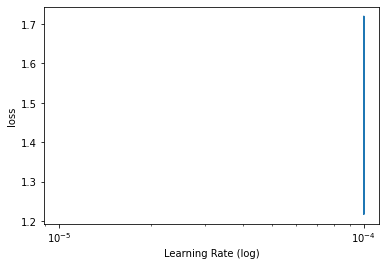

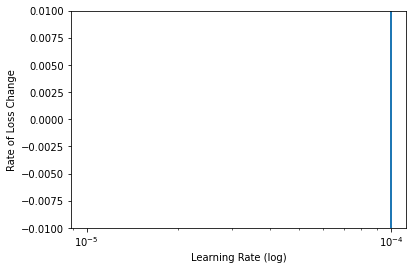

In [ ]:
# initialize lr finder object
lr_finder = LRFinder(model)

# find lr
lr_finder.find(train_dataset, start_lr = 0.0001, end_lr = 1, batch_size=BATCH_SIZE, epochs=5)

# plot loss
lr_finder.plot_loss()

# plot rate of loss change
lr_finder.plot_loss_change()

Oops didn't seem to work. Let's try one-hot encoding for the input vectors

## One-Hot Encoding Model

#### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, Input, LSTM, Flatten, Dense, Dropout
from tensorflow.keras import Model
import numpy as np 

from pprint import pprint as pp
from string import punctuation
import regex as re
import random
import os

#### Loading Data

In [ ]:
path = r"/content/drive/MyDrive/Colab Notebooks/predictive_keyboard/data/lotr_full.txt"

In [ ]:
with open(path, "r", encoding="utf-8") as f:
    text = f.read()
print(text[:1000])

Three Rings for the Elven-kings under the sky,
               Seven for the Dwarf-lords in their halls of stone,
            Nine for Mortal Men doomed to die,
              One for the Dark Lord on his dark throne
           In the Land of Mordor where the Shadows lie.
               One Ring to rule them all, One Ring to find them,
               One Ring to bring them all and in the darkness bind them
           In the Land of Mordor where the Shadows lie.
           
FOREWORD

This tale grew in the telling, until it became a history of the Great War of the Ring and included many glimpses of the yet more ancient history that preceded it. It was begun soon after _The Hobbit_ was written and before its publication in 1937; but I did not go on with this sequel, for I wished first to complete and set in order the mythology and legends of the Elder Days, which had then been taking shape for some years. I desired to do this for my own satisfaction, and I had little hope that other people 

In [ ]:
print(f"Corpus length: {int(len(text)) / 1000 } K characters")

Corpus length: 1532.723 K characters


In [ ]:
def standardize_text_string(text: str):
    """
        create a custom standardization that:
            1. Fixes whitespaces 
            2. Removes punctuations & numbers
            3. Sets all texts to lowercase
            4. Preserves the Elvish characters
    """
    
    text = re.sub(r"[\s+]", " ", text)
    text = re.sub(r"[0-9]", "", text)
    text = re.sub(f"[{punctuation}–]", "", text)

    return text.lower()

In [ ]:
# get unique characters in the text
chars = sorted(set(standardize_text_string(text)))

In [ ]:
print(chars, f"\n\nTotal unique characters: {len(chars)}")

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'â', 'ä', 'é', 'ë', 'í', 'ó', 'ú', 'û'] 

Total unique characters: 36


In [ ]:
# create dictionary mappings for chars to integers for vectorization & vice versa
char2int = {c: i for i, c in enumerate(chars)}
int2char = {i: c for c, i in char2int.items()}

In [ ]:
print(char2int)
print(int2char)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'á': 27, 'â': 28, 'ä': 29, 'é': 30, 'ë': 31, 'í': 32, 'ó': 33, 'ú': 34, 'û': 35}
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'á', 28: 'â', 29: 'ä', 30: 'é', 31: 'ë', 32: 'í', 33: 'ó', 34: 'ú', 35: 'û'}


In [ ]:
standardized_text = standardize_text_string(text)

In [ ]:
# preserve the same sequence length and step
MAX_SEQ_LEN = 20
step = 2
EMBEDDING_DIM = 16

# let's collect our sentences and next_chars again

sentences = []
next_chars = []

for i in range(0, len(standardized_text) - MAX_SEQ_LEN, step):
    sentences.append(standardized_text[i: i + MAX_SEQ_LEN])
    next_chars.append(standardized_text[i + MAX_SEQ_LEN])

print("Total number of training examples:", len(sentences))

Total number of training examples: 736848


In [ ]:
# get the total number of unique chars
N_UNIQUE_CHARS = len(chars)
m = len(sentences)
MAX_SEQ_LEN = MAX_SEQ_LEN # 20; (see above)

def vectorize_sentence(text, max_seq_len=MAX_SEQ_LEN, n_unique_chars=N_UNIQUE_CHARS):
    """ Convert input sentence into numpy vector of shape (m, max_seq_len, n_unique_chars) """
    if type(text) == str:
        # if text is input as string
        if len(text) > max_seq_len:
            # if text is longer than max_seq_len it will be truncated 
            ## and appended on the list
            text_list = []
            for i in range(0, len(text), max_seq_len):
                text_list.append(text[i: i+max_seq_len])
            text = text_list
        else:
            # if text is less than max_seq_len, convert str -> list(str)
            text = [text]
        
    
    m = len(text) # get total number of sentences

    x = np.zeros((m, max_seq_len, n_unique_chars), dtype=np.bool)
    for i, sentence in enumerate(text):
        # for each sentence in the `text` list
        for p, char in enumerate(sentence.lower()): 
            # p is the position of the letter in the sentence
            # char is the character in the sentence
            x[i, p, char2int[char]] = 1
    return x

In [ ]:
# try out sentence to ensure we get 
text_test = "ABCDEFGHIJKLMNOPQRSTUVWXYZ" + "ABCDEFGHIJKLMNOPQRSTUVWXYZ".lower()

text_test_vector = vectorize_sentence(text_test)
print("Shape of text vector: {}".format(text_test_vector.shape))
print(f"Supposed shape:{(round(len(text_test) / MAX_SEQ_LEN), MAX_SEQ_LEN, N_UNIQUE_CHARS)}")

Shape of text vector: (3, 20, 36)
Supposed shape:(3, 20, 36)


Nice! We got the right shape. Let's vectorize our `sentence` using the `vectorize_sentence` function

In [ ]:
# vectorize input sentences
X_data = vectorize_sentence(sentences);
print(X_data.shape)

(736848, 20, 36)


> Supposed shape: `(len(sentences), MAX_SEQ_LEN, N_UNIQUE_CHARS)`

In [ ]:
# vectorize next_chars (output) -> shape: (m, N_UNIQUE_CHARS)
y_data = np.zeros((m, N_UNIQUE_CHARS), dtype=np.bool)
for i, char in enumerate(next_chars):
    y_data[i, char2int[char]] = 1

print(y_data.shape)

(736848, 36)


In [ ]:
def char_LSTM_model(max_seq_len=MAX_SEQ_LEN, max_features=N_UNIQUE_CHARS, embedding_dim=EMBEDDING_DIM):

    # Define input for the model (vocab indices)
    inputs = tf.keras.Input(shape=(max_seq_len, max_features))

    # No embedding for one-hot encoding
    # X = Embedding((max_seq_len, max_features), (max_features, embedding_dim))(inputs)

    X = LSTM(128, return_sequences=True)(inputs)
    X = Flatten()(X)
    outputs = Dense(max_features, activation="softmax")(X)
    model = Model(inputs, outputs, name="model_LSTM")

    return model

In [ ]:
model_onehot = char_LSTM_model()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model_onehot.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model_onehot.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 20, 36)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 20, 128)           84480     
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 36)                92196     
                                                                 
Total params: 176,676
Trainable params: 176,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def sample(preds, temperature=0.2):
    # helper function to sample an index from a probability array  
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
    
def generate_text(model, seed_original, step, diversity):
    seed=vectorize_sentence(seed_original) # shape-> (1,20,36)
    # decode_sentence(seed.numpy().squeeze())
    print(f"Starting the sentence with.... '{seed_original}'")
    print("...Diversity:", diversity)
    # seed= vectorize_sentence(seed_original).reshape(1,-1)
    
    generated = (seed)
    for i in range(step):
        predictions=model.predict(seed)[0]
        next_index = sample(predictions, diversity)
        next_char = int2char[next_index]
        generated = np.append(generated, next_index)

    return decode_sentence(generated)


def decode_sentence (encoded_sentence):
    deceoded_sentence=[]
    for word in encoded_sentence:
        deceoded_sentence.append(int2char[word])
    sentence= ''.join(deceoded_sentence)
    print(sentence)
    return sentence

In [ ]:
for diversity in [0.2, 0.5, 1.0, 1.2]:
    generate_text(model_onehot, sentence, SAMPLING_STEPS, diversity)
    print()

Starting the sentence with.... 'as sleeping down at '
...Diversity: 0.2
 a                                                     a                a                                                      a                            a                            a                                   a                                              a                            a                                        a                            a                            a                                       a                                              a                                           a                          a                     a                                    a                                                      a               a                                   tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

Starting the sentence with.... 'as sleeping down at '
...Diversity: 0.5


KeyboardInterrupt: ignored

In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = r"/content/drive/MyDrive/Colab Notebooks/predictive_keyboard/models/one_hot/model_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 save_weights_only=True, 
                                                 verbose=1)

# Train the model
epochs = 30
BATCH_SIZE = 64
SAMPLING_STEPS = 100

for epoch in range(epochs):
    print("-"*40 + f"  Epoch: {epoch}/{epochs}  " + "-"*40)
    model_onehot.fit(X_data, y_data, batch_size=BATCH_SIZE, epochs=1, callbacks=[cp_callback])
    print()
    print("*"*30 + f" Generating text after epoch #{epoch} " + "*"*30)
    start_index = random.randint(0, len(text) - MAX_SEQ_LEN - 1)
    sentence = standardized_text[start_index : start_index + MAX_SEQ_LEN]
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        generate_text(model_onehot, sentence, SAMPLING_STEPS, diversity)
        print()

----------------------------------------  Epoch: 0/30  ----------------------------------------
11513/11514 [============================>.] - ETA: 0s - loss: 1.7822 - accuracy: 0.4664
Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/predictive_keyboard/models/one_hot/model_cp.ckpt
11514/11514 [==============================] - 114s 9ms/step - loss: 1.7822 - accuracy: 0.4664

****************************** Generating text after epoch #0 ******************************


NameError: ignored